# Part 0:
## import everything
Run the cell below

In [178]:
import os
import glob
import numpy as np
from platform import system as OS
import pandas as pd
import scipy.stats
import math
import datetime
from copy import deepcopy
import matplotlib.cm as cm
import warnings
warnings.filterwarnings("ignore")
import sys
import pickle
import matplotlib
import matplotlib.pyplot as plt
from scipy import stats
import matplotlib.animation as animation
import matplotlib.backends.backend_pdf
import mpl_toolkits.axes_grid1.inset_locator as inset
from matplotlib.ticker import FormatStrFormatter
from matplotlib.patches import ConnectionPatch
from set_rc_params import set_rc_params
import ROOT


if "__file__" not in dir():
    %matplotlib inline
    %config InlineBackend.close_figures = False

    root=ROOT.root
    
    ThisNoteBookPath=os.path.dirname(os.path.realpath("__file__"))
    CommonNoteBookesPath=os.path.join(os.path.split(ThisNoteBookPath)[0],"load_preprocess_rat")
    CWD=os.getcwd()
    os.chdir(CommonNoteBookesPath)
    %run UtilityTools.ipynb
    %run Animal_Tags.ipynb
    %run loadRat_documentation.ipynb
    %run plotRat_documentation_1_GeneralBehavior.ipynb
    %run plotRat_documentation_3_KinematicsInvestigation.ipynb
    %run RunBatchRat_3_CompareGroups.ipynb
    %run BatchRatBehavior.ipynb
    currentNbPath=os.path.join(os.path.split(ThisNoteBookPath)[0],'LesionPaper','ExampleRats.ipynb')
    %run $currentNbPath

    os.chdir(CWD)

    logging.getLogger().setLevel(logging.ERROR)
    
    param={
        "goalTime":7,#needed for pavel data only
        "treadmillRange":[0,90],#pavel error conversion "treadmillRange":[0,80]
        "maxTrialDuration":15,
        "interTrialDuration":10,#None pavel
        "endTrial_frontPos":30,
        "endTrial_backPos":55, 
        "endTrial_minTimeSec":4,
        "cameraSamplingRate":25, #needed for new setup    

        "sigmaSmoothPosition":0.1,#0.33, 0.18 pavel
        "sigmaSmoothSpeed":0.3,#0.3, 0.5 pavel
        "nbJumpMax":100,#200 pavel
        "binSize":0.25,
        #parameters used to preprocess (will override the default parameters)
    }
    Y1,Y2=param['treadmillRange']

    print('os:',OS(),'\nroot:',root,'\nImport successful!')

AttributeError: 'AxesSubplot' object has no attribute 'con'

os: Linux 
root: /data 
Import successful!


---
---


# part 1:

# DEFINITIONS

### If you don't know what to do, move to part 2

---

plotting the trajectories of example sessions

In [209]:
def plot_session_median_trajectory(data,ax):
    posDict=data.position
    maxL=np.nanmax(list(data.stopFrame.values()))
    maxL=int(maxL)
    position=np.ones((maxL,len(posDict.keys())))*np.nan
    time=np.arange(-data.cameraToTreadmillDelay,
                   (maxL-data.cameraSamplingRate)/data.cameraSamplingRate,
                   1/data.cameraSamplingRate)
    
    
    for i,trial in enumerate(posDict):
        pos=posDict[trial][:data.stopFrame[trial]]
        position[:len(pos),i]=pos
    
    #keeping data where 70% of points exist
    nanSum=np.sum(np.isnan(position),axis=1)
    try:
        maxTraj=np.where(nanSum>.3*position.shape[1])[0][0]
    except IndexError:
        maxTraj=position.shape[1]
    
    
    ax.plot(time[:maxTraj], np.nanmedian(position,axis=1)[:maxTraj], color='navy', lw=2)    

def plot_trajectories(data,ax):
    posDict=data.position
    time=data.timeTreadmill #align on camera
    Colors=[]
    for trial in posDict:
        color="xkcd:green"
        if trial not in data.goodTrials:
            color="salmon"
        Colors.append(color)
        ax.plot(time[trial][:data.stopFrame[trial]], posDict[trial][:data.stopFrame[trial]],
               color=color, lw=.5, )
            
    ax.fill_betweenx(y=(0,90),x1=0,x2=7, facecolor='gray', edgecolor=None, alpha=.4)
    
    return np.array(Colors)



def plot_trajectories_and_distributions(root, ax, session, showText=True):
    data=Data(root,session[:6],session,redoPreprocess=False)
    
    color=plot_trajectories(data,ax=ax)
    
    position=get_positions_array_beginning(data,onlyGood=False,raw=False)
    position=position.T
    
    plot_session_median_trajectory(data,ax)
    
    props={'color':'k', 'linewidth':1}
    ax.boxplot(x=data.entranceTime,whis=[5,95],vert=False,
               positions=[5], widths=5,
               showcaps=False, showfliers=False,
               medianprops=props, boxprops=props, whiskerprops=props, zorder=5
              )
    
    if showText:
        ax.set_xlim([-1,15.2])
        ax.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])
        ax.set_xticklabels([0,'','','','','','',7,'','','','','','','',15])
        ax.set_ylim([0,90])
        ax.set_yticks([0,10,20,30,40,50,60,70,80,90])
        ax.set_yticklabels([0,'','','','','','','','',90])
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_bounds(0,15)
        ax.set_xlabel('Trial time (s)',labelpad=0)
        ax.set_ylabel('Position (cm)',labelpad=-10)
    else:
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.tick_params(bottom=False, top=False, left=False, right=False,
                      labelbottom=False, labeltop=False, labelleft=False, labelright=False)
    
#======================================
def plot_pre_post_traj(root, gs, animal, preProfile, postProfile, preSession, postSession):
    
    assert len(preSession)+len(postSession) == gs.get_geometry()[1]
    axes=[]
    
    sessionList=batch_get_session_list(root, animalList=[animal], profile=preProfile)['Sessions']
    for i,sessionId in enumerate(preSession):
        session=sessionList[sessionId]
        ax= gs.figure.add_subplot(gs[i])
        plot_trajectories_and_distributions(root, ax, session, showText=i==0)
        axes.append(ax)
    
    sessionList=batch_get_session_list(root, animalList=[animal], profile=postProfile)['Sessions']
    for j,sessionId in enumerate(postSession):
        session=sessionList[sessionId]
        ax= gs.figure.add_subplot(gs[i+j+1])
        plot_trajectories_and_distributions(root, ax, session,showText=False)
        axes.append(ax)
    
    return axes

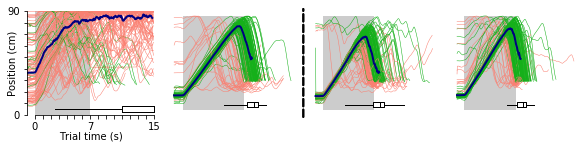

In [214]:
if "__file__" not in dir():
    #the inputs
    fig=plt.figure(figsize=(8,1.5))
    gs= fig.add_gridspec(nrows=1, ncols=4, left=0.02, bottom=0.02, right=0.98, top=.98, wspace=.1)
    

    
    profile1pre={'Type':'Good',
             'rewardType':'Progressive',
             'initialSpeed':'10',
             'Speed':'10',
             'Tag':['Control']
             }
    
    profile1post={'Type':'Good',
             'rewardType':'Progressive',
             'initialSpeed':'10',
             'Speed':'10',
             'Tag':['Control-AfterBreak']
             }
    animalList1Ctrl='Rat250'
    
    sessionIndex1pre =(0,-1)
    sessionIndex1post=(0,-1)
    
    plot_pre_post_traj(root, gs, animalList1Ctrl, profile1pre, profile1post, sessionIndex1pre, sessionIndex1post)
    gs.figure.add_artist(ConnectionPatch(xyA=(.5,0), xyB=(.5,1), coordsA='figure fraction', coordsB='figure fraction',
                                     ls='--',lw=2))

    
    plt.show()
    plt.close('all')

------



------

# part 2:

# GENERATING THE FIGURE

Definition of Parameters

In [ ]:
if "__file__" not in dir():
    # GRID 1 PARAMS
    
    profile1pre={'Type':'Good',
             'rewardType':'Progressive',
             'initialSpeed':'10',
             'Speed':'10',
             'Tag':['Control']
             }
    
    profile1post={'Type':'Good',
             'rewardType':'Progressive',
             'initialSpeed':'10',
             'Speed':'10',
             'Tag':['Control-AfterBreak']
             }
    animalList1Ctrl='Rat250'
    
    sessionIndex1pre =(-1,)
    sessionIndex1post=(0,4)

    
    #===============================================
    
    # GRID 2 PARAMS
    TaskParamToPlot2="standard deviation of entrance time"
    
    
    #================================================
    
    # GRID 3 PARAMS: entrance time examples
    Win3=2
    #plotting naive
    session3goodNaive    ='Rat123_2017_02_14_18_33'
    #plotting trained
    session3goodTrained  ='Rat123_2017_03_17_17_52'
    #plotting stupid naive animal
    session3badNiave     ='Rat132_2017_04_26_14_53'
    #plotting stupid trained animal
    session3badTrained   ='Rat132_2017_06_01_13_16'
    
    day123_0, day123_1, day132_0, day132_1=days=(2,25,3,28)
    #================================================
    
    # GRID 4: Trajectory examples
    
    #plotting naive
    trials4goodNaive=range(10,18)
    #plotting trained
    trials4goodTrained=range(50,59)
    #plotting stupid naive animal
    trials4badNiave=range(71,80)
    #plotting stupid trained animal
    trials4badTrained=range(115,125)
    #=================================================
    
    # GRID 5: AVERAGE TRAJECTORY
    SessionRange5=[20,30]
    Win5=2
    cs5=25
    
    
    #=================================================
    
    #GRID 6: Probablity of correct
    GT6=7
    distBins6=np.arange(0,130, 10)
    
    
    #=================================================
    
    #GRID 7: Percent Correct Trial
    PerfParam7= '% good trials'
        
    
    #=================================================
    
    #GRID 8: correlation of correct and distance   
    param8=[run_distance, "% good trials"]
            
    
    #=================================================
    # GENERAL
    colors=get_colors(colormap='plasma', n=0+1)[:-1]
    
    

Plotting the figure

In [ ]:
if "__file__" not in dir():
    plt.close('all')
    set_rc_params()
    figsize=(4,15)
    fig=plt.figure(figsize=figsize,dpi=600)
    
    
    ##########################################
    # 1: learning curve
    gs1= fig.add_gridspec(nrows=1, ncols=1, left=0.02, bottom=0.28, right=0.45, top=.44)
    ax1= fig.add_subplot(gs1[0])
    

    plot_trajectories_and_distributions(root, ax1, session)
    
    
    ##########################################
    # 2: goal time change
    gs2= fig.add_gridspec(nrows=1, ncols=1, left=.55, bottom=0.28, right=0.98, top=.44)
    ax2= fig.add_subplot(gs2[0])
#     D2= plot_dotted_learning_curve(ax2, root, animalList1, profile1, TaskParamToPlot2, stop_dayPlot1,colors, legend=False)
#     D2_=plot_learning_curve(ax2, root, animalList1Ctrl, profile1Ctrl, TaskParamToPlot2, stop_dayPlot1)
#     permTest2=TwoTailPermTest(group1=D2, group2=D2_, nIterations=10000)
#     permTest2.plotSignificant(ax=ax2,y=10.5,color=colorSig1,lw=2)

#     ax2.set_ylabel('$SD_{ET}$ (s)')
#     ax2.set_ylim([0,11])
#     ax2.set_yticks([0,3.5,7,10])
#     ax2.set_yticklabels([0,'',7,10])

    
    
    ###########################################
    # 3: Traj aligned on Entrance Time
    gs3= fig.add_gridspec(nrows=4, ncols=1, left=0.76, bottom=0.51, right=0.98, top=0.98)
    
    naiveAx3= fig.add_subplot(gs3[2])
#     plot_trajectories_aligned_on_entrance_time(root, naiveAx3, session3goodNaive, Win3)
    
#     trainedAx3= fig.add_subplot(gs3[3])
#     plot_trajectories_aligned_on_entrance_time(root, trainedAx3, session3goodTrained, Win3)
    
#     NaiveStupidAx3= fig.add_subplot(gs3[0])
#     plot_trajectories_aligned_on_entrance_time(root, NaiveStupidAx3, session3badNiave, Win3)
    
#     trainedStupidAx3= fig.add_subplot(gs3[1])
#     plot_trajectories_aligned_on_entrance_time(root, trainedStupidAx3, session3badTrained, Win3)
    
#     axes3=[naiveAx3, trainedAx3, NaiveStupidAx3, trainedStupidAx3]
#     for ax in axes3:
#         ax.set_ylabel('')
#         ax.set_yticklabels('')
#         ax.xaxis.set_visible(False)
#         ax.spines['bottom'].set_visible(False)
#     trainedAx3.xaxis.set_visible(True)
#     trainedAx3.spines['bottom'].set_visible(True)
#     trainedAx3.set_xlabel('         '+'Time to '+'$ET$'+' (s)')
    
    
    ###########################################
    # 4: consecutive trajectory examples
    gs4= fig.add_gridspec(nrows=4, ncols=1, left=0.02, bottom=0.51, right=0.75, top=0.98)
    
    naiveAx4= fig.add_subplot(gs4[2])
#     plot_consecutive_trajectories(root, session3goodNaive, trials4goodNaive, naiveAx4)
#     naiveAx4.text(x=0, y=0, s=f' {session3goodNaive[:6]} session {day123_0} ({markers1["naive"]})'
#                   ,fontsize='xx-small')
    
#     trainedAx4= fig.add_subplot(gs4[3])
#     plot_consecutive_trajectories(root, session3goodTrained, trials4goodTrained, trainedAx4)
#     trainedAx4.text(x=0, y=0, s=f' {session3goodTrained[:6]} session {day123_1} ({markers1["trained"]})'
#                     ,fontsize='xx-small')
    
#     NaiveStupidAx4= fig.add_subplot(gs4[0])
#     plot_consecutive_trajectories(root, session3badNiave, trials4badNiave, NaiveStupidAx4)
#     NaiveStupidAx4.text(x=0, y=80, s=f' {session3badNiave[:6]} session {day132_0} ({markers1["stupidNaive"]})'
#                         ,fontsize='xx-small')
    
#     trainedStupidAx4= fig.add_subplot(gs4[1])
#     plot_consecutive_trajectories(root, session3badTrained, trials4badTrained, trainedStupidAx4)
#     trainedStupidAx4.text(x=0, y=80, s=f' {session3badTrained[:6]} session {day132_1} ({markers1["stupidTrained"]})'
#                           ,fontsize='xx-small')
    
#     axes4=[NaiveStupidAx4, trainedStupidAx4,naiveAx4, trainedAx4]
#     timeMax=max([ax.get_xlim()[1] for ax in axes4])
#     for ax in axes4:
#         ax.set_xlim([0,timeMax])
#         ax.xaxis.set_visible(False)
#         ax.spines['bottom'].set_visible(False)
#         ax.spines['left'].set_bounds(0,90)
#         ax.set_ylabel('')
#         ax.set_yticks([0,45,90])
#         ax.set_yticklabels([' 0','','90'])
    
#     trainedAx4.xaxis.set_visible(True)
#     trainedAx4.spines['bottom'].set_visible(True)
#     trainedAx4.set_xlabel('Time (s)')
    
#     legend4=add_legend_for_consecutive_trajectories(NaiveStupidAx4)
    
#     totAx4=fig.add_subplot(gs4[:],frameon=False)
#     totAx4.set_ylabel('Position (cm)')
#     totAx4.xaxis.set_visible(False)
#     totAx4.set_ylim([0,10])
#     totAx4.set_yticks([10])
#     totAx4.tick_params(color=(0, 0, 0, 0),labelcolor=(0, 0, 0, 0),zorder=-10)
    
    
    
    ###########################################
    # 5: average trajectories
    gs5= fig.add_gridspec(nrows=1, ncols=1, left=0.02, bottom=0.02, right=0.23, top=0.20)
    ax5= fig.add_subplot(gs5[0])
#     plot_animal_median_trajectory(root,ax5,animalList1,profile1, Win5, cs5, SessionRange5,colors)

    
    ###########################################
    # 6: probabblity of correct
    gs6= fig.add_gridspec(nrows=1, ncols=1, left=0.76, bottom=0.02, right=0.98, top=0.20)
    ax6= fig.add_subplot(gs6[0])
#     plot_cond_prob_correct(ax6, animalList1, profile1, SessionRange5, GT6, distBins6,colors)


    ###########################################
    # 7: percent correct
    gs7= fig.add_gridspec(nrows=1, ncols=1, left=0.31, bottom=0.02, right=0.5, top=0.20)
    ax7= fig.add_subplot(gs7[0])    
#     plot_percent_correct(root,ax7,animalList1,profile1, PerfParam7, SessionRange5,colors)
#     ax7.set_xticklabels(ax7.get_xticklabels(),color=[0,0,0,0], rotation=0)
#     ax7.set_xlabel('Rat#')

    

    ############################################
    # 8: corelation  correct and distance 
    gs8= fig.add_gridspec(nrows=1, ncols=1, left=0.5, bottom=0.02, right=.7, top=0.20)
    ax8= fig.add_subplot(gs8[0])    

#     rm_corr8=plot_correct_distance_correlation(root, ax8, animalList1, profile1, param8, SessionRange5, colors)
#     ax8.set_ylabel('')
#     ax8.set_yticklabels('')
    
    #############################################
    #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#     AXES=(axes4[0],ax1,ax2,ax5,ax7,ax8,ax6)
#     OFFX=np.array([.07]*len(AXES))
#     OFFY=np.array([.01]*len(AXES))
#     OFFX[5]=0.03
#     OFFX[[0,1,2,4,6]]=0.05
    
#     add_panel_caption(axes=AXES, offsetX=OFFX, offsetY=OFFY)
    
#     fig.savefig(os.path.join(os.path.dirname(os.getcwd()),'LesionPaper','Figures','ExampleRats.pdf'),
#                 format='pdf', bbox_inches='tight')
    
    plt.show()
    plt.close('all')
    matplotlib.rcdefaults()